<a href="https://colab.research.google.com/github/anya-mb/Geo-Services/blob/main/geo_homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Бекетова Анна Михайловна`

Группа: `MADE-DS-12`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [2]:
# ! pip install overpy sympy OSMPythonTools geopandas

In [3]:
import math
import random
import numpy as np
import shapely.geometry as geometry
from shapely.geometry import Polygon, Point
import folium
import geopandas as gpd

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
afganistan = world[(world.name=="Afghanistan")]
afganistan

pop_est  ...                                           geometry
103  34124811  ...  POLYGON ((66.51861 37.36278, 67.07578 37.35614...

[1 rows x 6 columns]

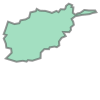

In [5]:
afganistan_poly = afganistan.geometry.values[0]
afganistan_poly

In [6]:
def get_random_points_within_poly(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

def haversine_distance(origin, destination):
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371000
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
      * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c
    return distance

def is_inside_poly(point, poly = afganistan_poly):
    return point.within(poly)

In [9]:
# coords are taken from Google Maps just to evaluate the biggest distance in Agfanistan in degree
left_corner_coords_afg = Point(60.878278, 29.860150)
right_corner_coords_afg = Point(74.885435, 37.256466)

line = geometry.LineString([left_corner_coords_afg, right_corner_coords_afg])

biggest_degree_dist = line.length
print(f'Biggest distance inside Afganistan in degrees: {round(biggest_degree_dist, 2)}')

middle_afg_coord = line.interpolate(0.5, normalized = True)
print(f'\nAfganistan middle point coord: ({middle_afg_coord.x, middle_afg_coord.y})')

biggest_radius_dist_agf_meters = haversine_distance((60.878278, 29.860150), (74.885435, 37.256466)) / 2

print(f'\n{round(biggest_radius_dist_agf_meters, 0)} meters the biggest radius distance (from the middle to any other point) in Afganistan')

Biggest distance inside Afganistan in degrees: 15.84

Afganistan middle point coord: ((67.8818565, 33.558308000000004))

766973.0 meters the biggest radius distance (from the middle to any other point) in Afganistan


In [10]:
def point_to_afg_in_meters(random_point, afg_coord = middle_afg_coord):
    return haversine_distance((random_point.x, random_point.y), (afg_coord.x, afg_coord.y))

meters_to_max_degree_dict = {i/10.0 : haversine_distance((0.0, 0.0), (0.0, i/10.0)) for i in range(5, 1805, 5)}

def find_max_degree_addition(dist_meters, meters_to_max_degree = meters_to_max_degree_dict):
    prev_deg = 0.1

    for deg, dist in meters_to_max_degree.items():
        if dist > dist_meters:
            return prev_deg
        else:
            prev_deg = deg

dist_example = 5_000_000
max_degree_addition = find_max_degree_addition(dist_example)

print(f'Example: for distance {dist_example} meters I will add {max_degree_addition} degrees to coordinates')

Example: for distance 5000000 meters I will add 44.5 degrees to coordinates


In [11]:
def get_new_search_polygon(point, distance = max_degree_addition, middle_afg_coord=middle_afg_coord):
    return Polygon([Point(min(point.x + distance, 180), point.y), 
                       Point(point.x, min(point.y + distance, 90)),
                       Point(max(point.x - distance, -180), point.y),
                       Point(point.x, max(point.y - distance, -90))])

def style_function(color):
    return lambda feature: dict(color=color,
                              weight=3,
                              opacity=0.7)

def step(random_point, zoom_value=2):
    reached_afg = False
    
    m = folium.Map(location=(middle_afg_coord.y, middle_afg_coord.x), zoom_start=zoom_value)
    folium.GeoJson(afganistan_poly).add_to(m)

    if is_inside_poly(random_point):
        folium.Marker((p_c.y, p_c.x), icon=folium.Icon(color='green')).add_to(m)
        reached_afg = True
        return (random_point, m, reached_afg)

    print(f"Coord: {random_point.x, random_point.y}")
    dist_to_afg_center = point_to_afg_in_meters(random_point)
    total_distance = dist_to_afg_center + biggest_radius_dist_agf_meters

    print("total_distance:", total_distance)

    max_degree_addition = find_max_degree_addition(total_distance)

    print("max_degree_addition:", max_degree_addition)

    search_poly = get_new_search_polygon(random_point, distance = max_degree_addition)

    points_candidates = get_random_points_within_poly(search_poly, num_points=5)
    points_candidates_dist = []

    for p_c in points_candidates:
        dist = point_to_afg_in_meters(p_c)
        points_candidates_dist.append(dist)
        if is_inside_poly(p_c):
            folium.Marker((p_c.y, p_c.x), icon=folium.Icon(color='green')).add_to(m)
            reached_afg = True
            return (p_c, m, reached_afg)

    nearest_point_pos = np.argmin(points_candidates_dist)
    nearest_point = points_candidates[nearest_point_pos]

    print(f"Coord nearest: {nearest_point.x, nearest_point.y}")
    
    folium.GeoJson(search_poly, style_function=style_function('yellow')).add_to(m)

    folium.Marker((random_point.y, random_point.x), popup='Previous point', icon=folium.Icon(color='darkgreen')).add_to(m)

    for candidate, dist in zip(points_candidates, points_candidates_dist):
        if candidate == nearest_point:
            folium.Marker((candidate.y, candidate.x), popup=f"{dist}m to Afganistan center", icon=folium.Icon(color='green')).add_to(m)
        else:
            folium.Marker((candidate.y, candidate.x), popup=f"{dist}m to Afganistan center", icon=folium.Icon(color='red')).add_to(m)

    return (nearest_point, m, reached_afg)

In [12]:
# random point on planet Earth
random_lat = random.uniform(-90, 90)
random_lon = random.uniform(-180, 180)

random_point = geometry.Point(random_lon, random_lat)
random_point.x, random_point.y

(-68.32237936942363, -41.09199926098581)

### Algorithm

1) Select random point on planet Earth

2) Calculate the distance between it and the middle point of Afganistan

3) Make a search polygone from this point on this distance + half the max distance in Afganistan

4) Generate 5 random points in search polygon, find the nearest to the middle point of Afganistan. The nearest is green, other 4 points are red, previous point (the middle of search polygon) is dark green, search polygon is yellow.

5) Repeat 1-4 for the nearest found green point until it reaches Afganistan polygon.

In [13]:
nearest_point, m, has_reached = step(random_point)
print(f"Reached: {has_reached}")
m

Coord: (-68.32237936942363, -41.09199926098581)
total_distance: 16862583.70002179
max_degree_addition: 151.5
Coord nearest: (34.72739457679597, -20.258544880834492)
Reached: False


In [14]:
nearest_point2, m, has_reached = step(nearest_point)
print(f"Reached: {has_reached}")
m

Coord: (34.72739457679597, -20.258544880834492)
total_distance: 7706982.192266897
max_degree_addition: 69.0
Coord nearest: (44.23509914740475, 32.067882896779764)
Reached: False


In [15]:
nearest_point3, m, has_reached = step(nearest_point2)
print(f"Reached: {has_reached}")
m

Coord: (44.23509914740475, 32.067882896779764)
total_distance: 2978252.2753293472
max_degree_addition: 26.5
Coord nearest: (56.596433823506224, 26.10316111596527)
Reached: False


In [16]:
nearest_point4, m, has_reached = step(nearest_point3, zoom_value=5)
print(f"Reached: {has_reached}")
m

Coord: (56.596433823506224, 26.10316111596527)
total_distance: 2133717.075225711
max_degree_addition: 19.0
Reached: True


In [17]:
nearest_point4.x, nearest_point4.y

(62.50636158005125, 34.07783435172028)

In [18]:
afg_point_coord = (nearest_point4.x, nearest_point4.y)

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [20]:
# !apt install libspatialindex-dev
# !pip install rtree

In [1]:
afg_point_coord = (62.50636158005125, 34.07783435172028)

In [2]:
import overpy
from rtree import index
import numpy as np
import tqdm
import math
import time
import folium
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

Building the list of all countries codes

In [3]:
overpass = Overpass()

countries = overpass.query('relation["admin_level"="2"][boundary=administrative];out;')
countries_json = countries.toJSON()

countries_codes_dict = {}

for element in countries_json["elements"]:
    try:
        two_letter_code = element['tags']['ISO3166-1']
        countries_codes_dict[two_letter_code] = element['tags']['name:en']
                                           
    except:
        continue

countries_list = list(countries_codes_dict.keys())

code = 'NL'
print(f"Number of counties: {len(countries_codes_dict.keys())}\n")
print(f"Example: Code: {code}, country: {countries_codes_dict[code]}")

Number of counties: 216

Example: Code: NL, country: Netherlands


### 1. Расстояние от точки до 5 ближайших банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости

In [4]:
def haversine_distance(origin, destination):
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371000
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
      * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = radius * c
    return distance

def reverse_coord(coord):
    return (coord[1], coord[0])

api = overpy.Overpass()

def get_number_of_residential_buildings_by_country_code(c_code):
    r = api.query(f"""
        area["ISO3166-1"="{c_code}"][admin_level=2];
        (node["building"="residential"](area);
        way["building"="residential"](area);
        rel["building"="residential"](area);
        );
        out center;
        """)
    
    number = 0
    number += (len(r.nodes) + len(r.ways) + len(r.ways))
    return number

def get_atm_coordinates_by_country_code(c_code):
    r = api.query(f"""
        area["ISO3166-1"="{c_code}"][admin_level=2];
        (node["amenity"="atm"](area);
        way["amenity"="atm"](area);
        rel["amenity"="atm"](area);
        );
        out center;
        """)
    
    coords  = []
    coords += [(float(node.lon), float(node.lat)) 
              for node in r.nodes]
    coords += [(float(way.center_lon), float(way.center_lat)) 
              for way in r.ways]
    coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in r.relations]

    return coords

In [5]:
res_buildings_numbers = []

for c_code in tqdm.tqdm(countries_list):
    try:
        number = get_number_of_residential_buildings_by_country_code(c_code)
        res_buildings_numbers.append(number)

    except overpy.exception.OverpassTooManyRequests:
        time.sleep(15)

100%|██████████| 216/216 [21:48<00:00,  6.06s/it]


In [6]:
position = np.argmax(res_buildings_numbers)
res_contry_code = countries_list[position]

print(f'Country with the biggest number of residential buildings: {countries_codes_dict[res_contry_code]} ({res_contry_code})')
print(f'It has {res_buildings_numbers[position]} residential buildings (marked on OSM)')

Country with the biggest number of residential buildings: Eswatini (SZ)
It has 96455 residential buildings (marked on OSM)


In [7]:
%%time
all_atm_coords = get_atm_coordinates_by_country_code(res_contry_code)

print(f"Number of ATM: {len(all_atm_coords)}")

Number of ATM: 33
CPU times: user 4.5 ms, sys: 0 ns, total: 4.5 ms
Wall time: 2.79 s


In [8]:
idx = index.Index()

for n, coord in enumerate(all_atm_coords):
    idx.insert(n, coord)

top_n = 5
nearest_pos = list(idx.nearest(afg_point_coord, top_n))
top5_nearest_atm_coords = [all_atm_coords[pos] for pos in nearest_pos]

top5_nearest_atm_coords

[(31.7548013, -25.9993918),
 (31.9199132, -26.2091923),
 (31.1410308, -26.3256225),
 (31.1409344, -26.3257659),
 (31.1410492, -26.326393)]

Plot of randomly found Afganistan point and top 5 nearest ATM's to it in the country with the biggest number of residential buildings

In [10]:
middle_coord = [(afg_point_coord[c_num] + top5_nearest_atm_coords[0][c_num]) / 2 for c_num in range(2)]

map_params = {'location': (reverse_coord(middle_coord)),
              'zoom_start': 4}

map = folium.Map(**map_params)

folium.Marker(reverse_coord(afg_point_coord)).add_to(map)

for atm_coord in top5_nearest_atm_coords:
    folium.Marker(reverse_coord(atm_coord),  
              icon=folium.Icon(icon='usd', icon_color = 'white')).add_to(map)

map

In [11]:
distances = [haversine_distance(afg_point_coord, atm_coord) for atm_coord in top5_nearest_atm_coords]

print("1. Расстояние от точки до 5 ближайших банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости")
print(f"{round(sum(distances)/1000, 3)} km")

1. Расстояние от точки до 5 ближайших банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
37326.581 km


### 2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице

In [ ]:
# afg_point_coord = (62.50636158005125, 34.07783435172028)

In [22]:
all_countries_capitals_info = api.query(f"""
relation["admin_level"="2"]["type"="boundary"]["boundary"="administrative"];
node(r:"admin_centre");
out meta;
""")

In [23]:
all_countries_capitals_info.nodes[0], len(all_countries_capitals_info.nodes)

(<overpy.Node id=107775 lat=51.5073219 lon=-0.1276474>, 217)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
nominatim = Nominatim()
country_code_to_info = {}

for node in all_countries_capitals_info.nodes:
    zoom_value = 10
    capital = nominatim.query(node.lat, node.lon, reverse=True, zoom=zoom_value);

    while capital.areaId() == None:
        zoom_value -= 1
        capital = nominatim.query(node.lat, node.lon, reverse=True, zoom=zoom_value)

    c_info = capital.address()
    area_id = capital.areaId()

    try:
        country_code_to_info[c_info['country_code'].upper()] = {"area_id" : area_id}
    except:
        continue

print(f'Found information about {len(country_code_to_info.keys())} capitals')

Found information about 214 capitals


In [26]:
overpass = Overpass()

pharmacy_counts = []
countries_list = list(country_code_to_info.keys())

for c_code in countries_list:
    areaId = country_code_to_info[c_code]['area_id']
    query = overpassQueryBuilder(area=areaId, elementType='node', selector='"amenity"="pharmacy"', out='count')
    result = overpass.query(query, timeout=120).countElements()
    pharmacy_counts.append(result)

In [27]:
position = np.argmax(pharmacy_counts)
pha_contry_code = countries_list[position]

print(f'Country with the biggest number of pharmacies in capital: {countries_codes_dict[pha_contry_code]} ({pha_contry_code})')
print(f'It has {pharmacy_counts[position]} pharmacies (marked on OSM)')

Country with the biggest number of pharmacies in capital: Russia (RU)
It has 3036 pharmacies (marked on OSM)


In [28]:
def get_school_coordinates_by_country_code(c_code):
    r = api.query(f"""
        area["ISO3166-1"="{c_code}"][admin_level=2];
        (node["building"="school"](area);
        way["building"="school"](area);
        rel["building"="school"](area);
        );
        out center;
        """)
    
    coords  = []
    coords += [(float(node.lon), float(node.lat)) 
              for node in r.nodes]
    coords += [(float(way.center_lon), float(way.center_lat)) 
              for way in r.ways]
    coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in r.relations]

    return coords

In [29]:
all_school_coords = get_school_coordinates_by_country_code(pha_contry_code)

print(f"Number of schools: {len(all_school_coords)}")

Number of schools: 109


In [19]:
idx = index.Index()

for n, coord in enumerate(all_school_coords):
    idx.insert(n, coord)

top_n = 5
nearest_pos = list(idx.nearest(afg_point_coord, top_n))
top5_nearest_school_coords = [all_school_coords[pos] for pos in nearest_pos]

top5_nearest_school_coords

[(47.6311272, 42.8979454),
 (47.4478689, 43.000008),
 (47.0388233, 42.4643327),
 (47.0381778, 42.463874),
 (47.0383265, 42.4647092)]

In [30]:
middle_coord = [(afg_point_coord[c_num] + top5_nearest_school_coords[0][c_num]) / 2 for c_num in range(2)]

map_params = {'location': (reverse_coord(middle_coord)),
              'zoom_start': 4}

map = folium.Map(**map_params)

folium.Marker(reverse_coord(afg_point_coord)).add_to(map)

for atm_coord in top5_nearest_school_coords:
    folium.Marker(reverse_coord(atm_coord),  
              icon=folium.Icon(icon='bell', icon_color = 'white')).add_to(map)

map

In [31]:
distances_sch = [haversine_distance(afg_point_coord, sch_coord) for sch_coord in top5_nearest_school_coords]

print("2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице")
print(f"{round(sum(distances_sch)/1000, 3)} km")

2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
8169.567 km


Actually, several days ago the country with the biggest number of residential buildings was the USA, but reruning the same code today led to an African country.

The same with the country with the biggest number of pharmacies: before it was Spain and now the same code outputs Russia.

May be some data was added recently.

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
# !pip install openrouteservice geopandas overpy

In [ ]:
import json
import requests
import geopandas as gpd
import pandas as pd
import overpy
import folium
import pyproj
from shapely import wkt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import transform
from openrouteservice import client

In [ ]:
api_key = "my-key"
api = overpy.Overpass()

Let's imagine you start from the Central Park Zoo to the 5th avenue. It would be near the intersection of streets E 65th st and 5th avenue.

The finish point is the intersection of Water Street and Washington Street.

In [ ]:
start_point = api.query("""
area[admin_level='5'][name='New York'];
(way[highway][name="East 65th Street"](area)->.w1;
way[highway][name="5th Avenue"](area)->.w2;
node(w.w1)(w.w2););
out;
""")

start_point_coord = (float(start_point.nodes[0].lat), float(start_point.nodes[0].lon))
print(f"Start point coordinates {start_point_coord}")

finish_point = api.query("""
area[admin_level='5'][name='New York'];
(way[highway][name="Water Street"](area)->.w1;
way[highway][name="Washington Street"](area)->.w2;
node(w.w1)(w.w2););
out;
""")

finish_point_coord = (float(finish_point.nodes[0].lat), float(finish_point.nodes[0].lon))
print(f"Finish point coordinates {finish_point_coord}")

Start point coordinates (40.768025, -73.970281)
Finish point coordinates (40.7032012, -73.98958)


In [ ]:
# Create new map to start from scratch
middle_coord = [(start_point_coord[c_num] + finish_point_coord[c_num]) / 2 for c_num in range(2)]

map_params = {'location': (middle_coord),
              'zoom_start': 13}
map = folium.Map(**map_params)


folium.Marker(start_point_coord, popup = 'Start point', 
              icon=folium.Icon(icon='play-circle', icon_color = 'white', color='green')).add_to(map)

folium.Marker(finish_point_coord, popup = 'Finish point', 
              icon=folium.Icon(icon='stop', icon_color = 'white', color='red')).add_to(map)

map

Uploading obstacles - New York City schools

In [ ]:
# working in google colab
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/MADE_geo/hw_2/'
schools_filename = '2019_-_2020_School_Point_Locations.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
schools_info = gpd.read_file(data_path + schools_filename)
print(schools_info.shape)
schools_info.head()

(1992, 19)


the_geom ATS_Code  ... YCoordinat geometry
0   POINT (-73.85554326311143 40.70843092338607)   75Q233  ...     197410     None
1   POINT (-73.98866531387878 40.76132731795493)   02M212  ...     216649     None
2   POINT (-73.73770240439862 40.71098671281902)   29Q034  ...     198417     None
3   POINT (-73.94070782764723 40.66180674321865)   17K091  ...     180396     None
4  POINT (-74.19343130285691 40.528152084906814)   31R455  ...     131756     None

[5 rows x 19 columns]

In [ ]:
schools_info['geometry'] = schools_info['the_geom'].apply(wkt.loads)
schools_info = schools_info[["Address", "geometry"]]

school_coord_list = [(school.x, school.y) for school in schools_info.geometry.values]
school_address_list = schools_info.Address.values

print(f"Example: \nSchool: {school_address_list[0]}, coordinates: {school_coord_list[0]}")

Example: 
School: 91-30 METROPOLITAN AVENUE, coordinates: (-73.85554326311143, 40.70843092338607)


In [ ]:
def reverse_coord(coord):
    return (coord[1], coord[0])

In [ ]:
# here Markers are clickable and if clicked it shows a school address

school_map = folium.Map(location=middle_coord, zoom_start=13)

for s_coord, address in zip(school_coord_list, school_address_list):
    folium.Marker(location=reverse_coord(s_coord), popup=address,
                  icon=folium.Icon(icon='bell', icon_color = 'white', color='blue')
                  ).add_to(school_map)

school_map

Building polygons with radius 50 meters around schools

In [ ]:
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32618')

proj_to = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
proj_from = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform

def createBufferPolygon(point, radius=50, resolution=10):
    utm_point = transform(proj_to, point)
    buffer = Point(utm_point).buffer(radius, resolution=resolution)
    polygon = []
    for point_ in buffer.exterior.coords:
        polygon.append(transform(proj_from, Point(point_)))
    return polygon

school_boxes = [createBufferPolygon(Point(s)) for s in school_coord_list]

Building direct route that just goes from the start point to the finish point

In [ ]:
clnt = client.Client(key=api_key)

# GeoJSON style function for routes
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=3,
                              opacity=0.7)

# Request direct route without taking schools into account
request_params = {'coordinates': [reverse_coord(start_point_coord), reverse_coord(finish_point_coord)],
                'format_out': 'geojson',
                'profile': 'driving-car',
                'preference': 'shortest',
                'instructions': 'false',}

route_direct = clnt.directions(**request_params)
folium.features.GeoJson(data=route_direct, name='Direct route', style_function=style_function('red'), overlay=True).add_to(map)

In [ ]:
# Buffer route with 0.02 degrees for better visualisation
route_buffer = LineString(route_direct['features'][0]['geometry']['coordinates']).buffer(0.02)
folium.features.GeoJson(data=mapping(route_buffer), name='Route Buffer', style_function=style_function('yellow'), overlay=True).add_to(map)

# Plot schools in 0.02 degrees buffer
# this time with Circles as they reflect boundaries
schools_buffer_poly = []
for school_box, s_coord in zip(school_boxes, school_coord_list):
    poly = Polygon(school_box)
    if route_buffer.intersects(poly):
        folium.Circle(radius=50, location=reverse_coord(s_coord), color='red', fill=False).add_to(map)
        schools_buffer_poly.append(poly)                        

In [ ]:
map

Building the route that avoids being at least 50 meters around shcools

In [ ]:
request_params['options'] = {'avoid_polygons': mapping(MultiPolygon(schools_buffer_poly))}
route_detour = clnt.directions(**request_params)

folium.features.GeoJson(data=route_detour, name='Route far from schools', style_function=style_function('green'), overlay=True).add_to(map)

map.add_child(folium.map.LayerControl())
map

Green Marker - starting point from Central Park with the entrance near Central Park Zoo to 5th Avenue

Red Marker - finishing point of intersection of Water Street and Washington Street

Red circles - areas within 50 meters from official schools coordinates 

Red route - direct route from Green Marker to Red Marker

Green Route doesn't navigate a car to move withtin 50 meters from schools or closer